# Model-Based Design of Experiments

This notebook is based on an example from:

[Jialu Wang](https://github.com/jialuw96) and [Alexander Dowling](https://github.com/adowling2) (2022), [Pyomo.DoE: An Open-Source Package for Model-Based Design of Experiments in Python](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.17813) . *AIChE Journal*, 68(12), e17813.


## Learning Objectives
* Practice nonlinear regression basics on a reaction kinetics example
* Interpret eigendecomposition of Fisher information matrix to determine which paramters (if any) are not identifiable
* Use A-, D-, and E-optimality to recommend the next experiment that maximizes information gain

## Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.linalg as linalg
from matplotlib import cm

## Mathematical Model for Reaction Kinetics Example

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goal is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

The concenration in a **batch reactor** evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
def batch_rxn_model(theta, t, CA0, T):
    '''
    
    Predict batch reaction performance
    
    Arugments:
        t: time, [hour], scalar or Numpy array
        theta: fitted parameters: A1, A2, E1, E2
        CA0: initial concentration, [mol/L], scalar or numpy array
        T: temperature, [K], scalar or Numpy array
    Returns:
        CA, CB, CC: Concentrations at times t, [mol/L], three scalars or numpy arrays
    '''
    
    def kinetics(A, E, T):
        ''' Computes kinetics from Arrhenius equation
        Arguments:
            A: pre-exponential factor, [1 / hr]
            E: activation energy, [kJ / mol]
            T: temperature, [K]
        Returns:
            k: reaction rate coefficient, [1/hr] or [1/hr*L/mol]
        '''
        R = 8.31446261815324 # J / K / mole

        return A * np.exp(-E*1000/(R*T))

    # units: [1/hr]
    k1 = kinetics(theta[0], theta[2], T)

    # units: [1/hr]
    k2 = kinetics(theta[1], theta[3], T)

    # units: [mol / L]
    CA = CA0 * np.exp(-k1*t);
    CB = k1*CA0/(k2-k1) * (np.exp(-k1*t) - np.exp(-k2*t));
    CC = CA0 - CA - CB;

    return CA, CB, CC


Now let's test the code by running it.

In [3]:
theta_true = [85., 370., 7.5, 15]
time_exp = np.linspace(0,1,11) # hr
CA0_exp1 = 1.0 # mol/L
T_exp1 = 400 # K
CA_exp1, CB_exp1, CC_exp1 = batch_rxn_model(theta_true, time_exp, CA0_exp1, T_exp1)

## Generate Synthetic Experimental Dataset

Let's construct a dataset containing: 
* Batch experiment at $T=400$ K and $C_{AO}=1.0$ mol/L
* Batch experiment at $T=300$ K and $C_{AO}=3.0$ mol/L

We also simulated the first experiment. Let's simulate the second.

In [4]:
theta_true = [85., 370., 7.5, 15]
CA0_exp2 = 3.0 # mol/L
T_exp2 = 300 # K
CA_exp2, CB_exp2, CC_exp2 = batch_rxn_model(theta_true, time_exp, CA0_exp2, T_exp2)

Next let's add random normally distributed noise.

In [5]:
n_time = len(time_exp)

noise_std_dev = 0.05

CA_exp1 += noise_std_dev*np.random.normal(size=n_time)
CA_exp2 += noise_std_dev*np.random.normal(size=n_time)
CB_exp1 += noise_std_dev*np.random.normal(size=n_time)
CB_exp2 += noise_std_dev*np.random.normal(size=n_time)
CC_exp1 += noise_std_dev*np.random.normal(size=n_time)
CC_exp2 += noise_std_dev*np.random.normal(size=n_time)

Now we'll package these into a numpy array:

In [6]:
# Create empty array for experiment 1
exp1 = np.zeros((n_time,7))

# Assign 1 to column 0. This is the experiment number.
exp1[:,0] = 1

# Copy CA0 into column 1
exp1[:,1] = CA0_exp1

# Copy T into column 2 
exp1[:,2] = T_exp1

# Copy time data into column 3
exp1[:,3] = time_exp

# Copy concentration data into remaining columns
exp1[:,4] = CA_exp1
exp1[:,5] = CB_exp1
exp1[:,6] = CC_exp1

print(exp1)

[[ 1.00000000e+00  1.00000000e+00  4.00000000e+02  0.00000000e+00
   9.75731747e-01 -1.79404622e-02 -4.99898372e-02]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  1.00000000e-01
   4.23531853e-01  4.25008014e-01  8.28784789e-02]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  2.00000000e-01
   1.18111238e-01  4.58135931e-01  3.16979286e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  3.00000000e-01
   5.56110960e-02  4.40172370e-01  5.76083550e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  4.00000000e-01
   7.46239431e-02  2.83477512e-01  6.18007356e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  5.00000000e-01
   6.35556229e-03  1.75563584e-01  7.24593739e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  6.00000000e-01
   7.82081342e-03  1.55223143e-01  7.89222670e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  7.00000000e-01
  -5.88665979e-02  1.25935755e-01  8.81828373e-01]
 [ 1.00000000e+00  1.00000000e+00  4.00000000e+02  8.00000000e-0

In [7]:
# Create empty array for experiment 2
exp2 = np.zeros((n_time,7))

# Assign 2 to column 0. This is the experiment number.
exp2[:,0] = 2

# Copy CA0 into column 1
exp2[:,1] = CA0_exp2

# Copy T into column 2 
exp2[:,2] = T_exp2

# Copy time data into column 3
exp2[:,3] = time_exp

# Copy concentration data into remaining columns
exp2[:,4] = CA_exp2
exp2[:,5] = CB_exp2
exp2[:,6] = CC_exp2

print(exp2)

[[ 2.00000000e+00  3.00000000e+00  3.00000000e+02  0.00000000e+00
   2.92333853e+00  6.28769233e-03  8.42187005e-02]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  1.00000000e-01
   1.92278961e+00  1.02189701e+00  3.17941285e-02]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  2.00000000e-01
   1.22887648e+00  1.55901637e+00  8.33284299e-02]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  3.00000000e-01
   8.50371080e-01  1.81403683e+00  2.90077548e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  4.00000000e-01
   5.57301711e-01  1.94556780e+00  4.93798482e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  5.00000000e-01
   4.32423845e-01  1.91306180e+00  6.26196775e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  6.00000000e-01
   2.11675963e-01  1.94792233e+00  8.21655674e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  7.00000000e-01
   1.18850613e-01  1.82019304e+00  9.51982568e-01]
 [ 2.00000000e+00  3.00000000e+00  3.00000000e+02  8.00000000e-0

In [8]:
# Vertically stack data
exps = np.vstack((exp1,exp2))

# Create a dataframe with specific columns
# Pro Tip: Use 'temp' for temeprature instead of 'T'.
#   'T' can be confused with transpose.
df = pd.DataFrame(exps, columns=['exp', 'CA0','temp','time', 'CA','CB','CC'])

df.head()

,exp,CA0,temp,time,CA,CB,CC
0,1.0,1.0,400.0,0.0,0.975732,-0.017940,-0.049990
1,1.0,1.0,400.0,0.1,0.423532,0.425008,0.082878
2,1.0,1.0,400.0,0.2,0.118111,0.458136,0.316979
3,1.0,1.0,400.0,0.3,0.055611,0.440172,0.576084
4,1.0,1.0,400.0,0.4,0.074624,0.283478,0.618007


Finally, let's plot the data and the true model.

In [9]:
def plot_data_and_model(theta_, data1):
    '''
    Plot regression results

    Args:
        theta: model parameters
        data: Pandas data frame

    Returns:
        Nothing
    '''
    
    # Set axed font size
    fs = 20

    # loop over experiments
    for i in data1.exp.unique():

        ## Plot 1: Data Versus Prediction
        
        # delcare figure object
        fig, ax = plt.subplots(figsize=(6,4))
        # select the rows that correspond to the specific experiment number
        j = (data1.exp == i)

        # determine experiment conditions
        CA0_ = float(data1.CA0[j].mode())
        T_ = float(data1.temp[j].mode())
        
        # Plot dataset 1
        plt.plot(data1.time[j], data1.CA[j], marker='o',markersize=16,linestyle="",color="blue",label="$C_{A}$ Data")
        plt.plot(data1.time[j], data1.CB[j], marker='s',markersize=16,linestyle="",color="green",label="$C_{B}$ Data")
        plt.plot(data1.time[j], data1.CC[j], marker='^',markersize=16,linestyle="",color="red",label="$C_{C}$ Data")

        
        # determine time set
        t_plot = np.linspace(np.min(data1.time[j]),np.max(data1.time[j]),21)
        
        # Evaluate model
        CA_, CB_, CC_ = batch_rxn_model(theta_,t_plot,CA0_,T_)
        
        # Plot model predictions
        plt.plot(t_plot, CA_, linestyle="-",color="blue",label="$C_{A}$ Model",linewidth=4)
        plt.plot(t_plot, CB_, linestyle=":",color="green",label="$C_{B}$ Model",linewidth=4)
        plt.plot(t_plot, CC_, linestyle="--",color="red",label="$C_{C}$ Model",linewidth=4)

        # Add "extras" to the plot
        plt.xlabel("Time [hours]",fontsize = fs, fontweight = 'bold')
        plt.ylabel("Concentration [mol L$^{-1}$]",fontsize = fs, fontweight = 'bold')
        plt.title("Experiment "+str(round(i))+":  T="+str(T_)+" K,  CA$_0$="+str(CA0_)+" mol L$^{-1}$",fontsize=fs,loc='left', fontweight='bold')
        plt.legend(fontsize=fs,loc='center left',bbox_to_anchor=(1.0, 0.5))
        
        # define tick size
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs)
        plt.tick_params(direction="in",top=True, right=True)
        
        plt.grid(False)
        plt.show()

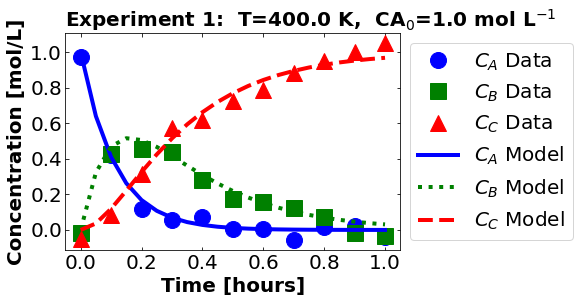

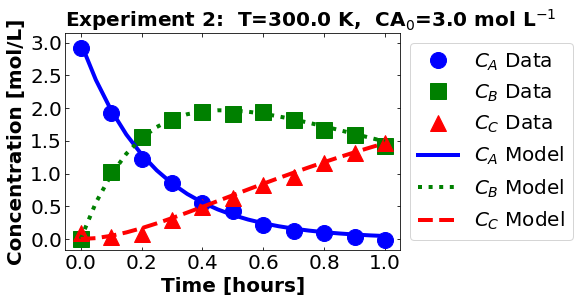

In [10]:
plot_data_and_model(theta_true, df)

## Perform Nonlinear Regression

### Solve Nonlinear Least Squares Problem

In [11]:
# nonlinear parameter estimation with full physics model
def regression_func(theta, data):
    '''
    Function to define regression function for least-squares fitting
    
    Note: This only uses CB measurements
    
    Arguments:
        theta: parameter vector
        data: Pandas data frame
    Returns:
        e: residual vector
    '''
    # determine number of entries in data frame
    n = len(data)

    # initialize matrix of residuals
    # rows: each row of Pandas data frame
    # columns: species CA, CB, CC
    e = np.zeros(n)

    # loop over experiments
    for i in data.exp.unique():

        # select the rows that correspond to the specific experiment number
        j = (data.exp == i)

        # determine experiment conditions
        CA0_ = float(data.CA0[j].mode())
        T_ = float(data.temp[j].mode())

        # determine experiment time
        t = data.time[j].to_numpy()

        CA, CB, CC = batch_rxn_model(theta,t,CA0_,T_)

        # Only use CB measurements
        e[j] = CB - data.CB[j]

    return e

Let's test our function.

In [12]:
e_test = regression_func(theta_true, df)
print(e_test)

[ 0.01794046  0.04529744  0.0478421  -0.02422186  0.02587734  0.04369025
 -0.00380103 -0.02289042 -0.00363811  0.0660037   0.06420974 -0.00628769
 -0.04071488 -0.01823045  0.01678605  0.00493699  0.05135578 -0.03346857
  0.00745277  0.05189338  0.00933698  0.07090766]


Finally, we can compute the best fit estimate.

In [13]:
# Initial guess
theta0 = [85., 370., 7.5, 15]

# Bounds
bnds = ([50, 300, 5, 10,], [200, 400, 20, 50])

# Define function that includes data
my_func = lambda theta_ : regression_func(theta_, df)

# Perform nonlinear least squares
nl_results = optimize.least_squares(my_func, theta0, bounds=bnds, method='trf',verbose=2)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5408e-02                                    3.36e-01    
       1              2         1.1625e-02      3.78e-03       6.16e+00       4.15e-02    
       2              3         1.1053e-02      5.72e-04       2.98e+01       3.48e-02    
       3              4         1.0856e-02      1.97e-04       3.36e+00       1.64e-02    
       4              5         1.0769e-02      8.67e-05       8.08e+00       8.07e-02    
       5              6         1.0757e-02      1.22e-05       6.72e-03       5.09e-02    
       6              7         1.0653e-02      1.04e-04       7.65e-01       3.77e-03    
       7              8         1.0641e-02      1.24e-05       5.41e+00       5.15e-02    
       8              9         1.0607e-02      3.41e-05       6.53e-02       5.43e-04    
       9             10         1.0606e-02      7.86e-07       6.76e-01       8.76e-04    

In [14]:
theta_hat = nl_results.x
print("theta_hat =",theta_hat)

theta_hat = [ 52.02384387 400.           6.21977848  15.09739218]


### Visualize Results

First let's plot the data and model predictions.

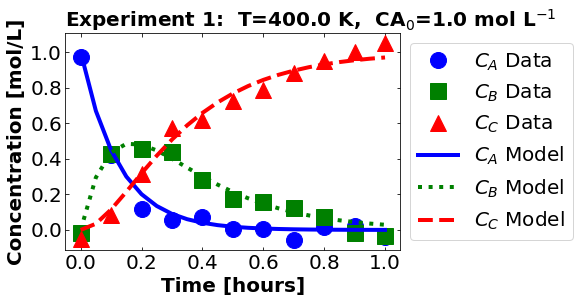

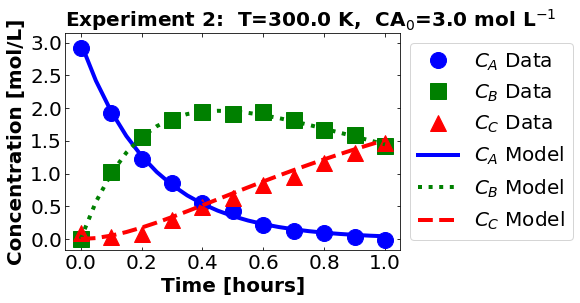

In [15]:
plot_data_and_model(theta_hat, df)

Next, let's look at the residuals. Recall, we only used $C_{B}$ in our regression formulation.

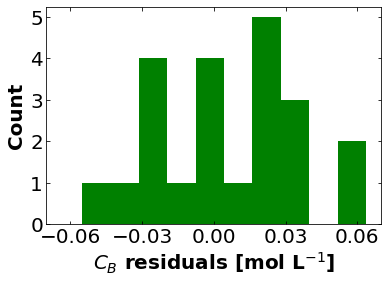

In [44]:
CB_residuals = regression_func(theta_hat, df)

# define font size
fs = 20

plt.hist(CB_residuals,color='green')
plt.xlabel("$C_{B}$ residuals [mol L$^{-1}$]",fontsize=fs,fontweight = 'bold')
plt.ylabel("Count",fontsize=fs,fontweight = 'bold')

# define tick size
plt.xlim((-0.07,0.07))
plt.xticks(fontsize=fs,ticks=np.arange(-0.06,0.07,0.03))
plt.yticks(fontsize=fs)
plt.tick_params(direction="in",top=True, right=True)

# finish plot
plt.show()

### Estimate Uncertainty

First let's estimate the variance of the residuals.

In [17]:
sigre = (CB_residuals.T @ CB_residuals)/(len(CB_residuals) - len(theta_hat))

How does the standard deviation of the residuals compare to the standard deviation of the measurement noise?

In [18]:
print("Estimated Standard Deviation of Residuals =",np.sqrt(sigre),"mol/L")
print("Standard Deviation of Measurement Error in Synthetic Data =",noise_std_dev,"mol/L")

Estimated Standard Deviation of Residuals = 0.03432842941885925 mol/L
Standard Deviation of Measurement Error in Synthetic Data = 0.05 mol/L


Estimating the covariance matrix using a linearization approximation is easy!

In [19]:
Sigma_theta = sigre * np.linalg.inv(nl_results.jac.T @ nl_results.jac)
print("Covariance matrix:\n",Sigma_theta)

Covariance matrix:
 [[ 4.31710287e+02 -2.24632027e+02  2.08623925e+01 -1.37034026e+00]
 [-2.24632027e+02  6.51269456e+03 -1.05362493e+01  4.14373475e+01]
 [ 2.08623925e+01 -1.05362493e+01  1.01072715e+00 -6.37570643e-02]
 [-1.37034026e+00  4.14373475e+01 -6.37570643e-02  2.65257890e-01]]


Recall the rows/colums are $A_1$, $A_2$, $E_1$, and $E_2$.

We can easily convert this to a correlation matrix.

In [20]:
corr_theta = Sigma_theta.copy()
for r in range(len(theta_hat)):
    for c in range(len(theta_hat)):
        corr_theta[r,c] = corr_theta[r,c]/np.sqrt(Sigma_theta[r,r])/np.sqrt(Sigma_theta[c,c])
        
print("Correlation matrix:\n",corr_theta)

Correlation matrix:
 [[ 1.         -0.13396616  0.99873656 -0.12805545]
 [-0.13396616  1.         -0.12986398  0.99695932]
 [ 0.99873656 -0.12986398  1.         -0.12313377]
 [-0.12805545  0.99695932 -0.12313377  1.        ]]


Discussion: Why are the pairs $A_1$, $E_2$ and $A_2$, $E_2$ highly correlated when measuring only $C_B$?

## Fisher Information Matrix

### Model Sensitivity

The first step of calculating the Fisher Information Matrix (FIM) is computing the sensitivity of all model outputs to each model parameter.

In [21]:
def calc_model_output(theta_,data):
    '''
    Assembles matrix out model outputs (columns) by experimental conditions (rows)
    
    Arguments:
        theta_: values of theta parameters, numpy array
        data: data frame of experimental conditions
    
    Returns:
        model_output: matrix
    '''
    
    # Allocate matrix of model outputs
    model_output = np.zeros((len(data),3))
    
    # Iterate over rows in pandas dataframe (each row is an experiment)
    for i,r in data.iterrows():
        # Evaluate model and store results
        model_output[i,:] = batch_rxn_model(theta_, r.time, r.CA0, r.temp)
        
    return model_output

# Test function at nominal values
print(calc_model_output(theta_hat,df))

[[ 1.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 4.48576777e-01  4.36211991e-01  1.15211232e-01]
 [ 2.01221125e-01  4.80244036e-01  3.18534839e-01]
 [ 9.02631236e-02  4.01069503e-01  5.08667373e-01]
 [ 4.04899411e-02  3.01017593e-01  6.58492466e-01]
 [ 1.81628473e-02  2.14035562e-01  7.67801591e-01]
 [ 8.14743149e-03  1.47552177e-01  8.44300392e-01]
 [ 3.65474856e-03  9.98118939e-02  8.96533358e-01]
 [ 1.63943533e-03  6.67080386e-02  9.31652526e-01]
 [ 7.35412616e-04  4.42331359e-02  9.55031452e-01]
 [ 3.29889021e-04  2.91769487e-02  9.70493162e-01]
 [ 3.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 1.95192238e+00  9.96937565e-01  5.11400501e-02]
 [ 1.27000033e+00  1.55608557e+00  1.73914099e-01]
 [ 8.26314025e-01  1.83842473e+00  3.35261249e-01]
 [ 5.37633614e-01  1.94797432e+00  5.14392066e-01]
 [ 3.49806362e-01  1.95175696e+00  6.98436675e-01]
 [ 2.27598290e-01  1.89278267e+00  8.79619039e-01]
 [ 1.48084732e-01  1.79849154e+00  1.05342373e+00]
 [ 9.63499678e-02  1.68624205e+

We'll use finite difference to estimate the sensitivities.

In [22]:
def calc_model_sensitivity(theta_,data,verbose=False):
    '''
    Estimate the model sensitivity matrix using forward finite difference
    
    Arguments:
        model_function: Python function that computes model outputs
        theta_: nominal value of theta
        exp_design_df: data frame containing experimental data
    '''
    
    # Evaluate model at nominal point
    nominal_output = calc_model_output(theta_,data)
    
    # Extract number of experiments and number of measured/output variables
    (n_exp, n_output) = nominal_output.shape
    
    # Set finite difference step size
    eps = 1E-5
    
    # Extract number of parameters
    n_param = len(theta_)
    
    # Create list to store model sensitity matrices
    model_sensitivity = []
    
    # Loop over number of outputs
    for i in range(n_output):
        
        # Allocate empty sensitivty matrix
        model_sensitivity.append(np.zeros((n_exp,n_param)))
    
    # Loop over parameters
    for p in range(n_param):
        
        # Create perturbation vector
        perturb = np.zeros(n_param)
        perturb[p] = eps
        
        # Forward and backward perturbation simulations
        output_forward = calc_model_output(theta_ + perturb, data)
        output_backward = calc_model_output(theta_ - perturb, data)
        
        sensitivity = (output_forward - output_backward) / (2*eps)
        if verbose:
            print("\nparam ",p)
            print("sens:\n",sensitivity)
        
        # Loop over outputs
        for o in range(n_output):
            # Copy sensitivity results
            model_sensitivity[o][:,p] = sensitivity[:,o].copy()
    
    return model_sensitivity

model_sensitivity = calc_model_sensitivity(theta_hat, df)

print("CA sensitivity:\n",model_sensitivity[0])
print("CB sensitivity:\n",model_sensitivity[1])
print("CC sensitivity:\n",model_sensitivity[2])

CA sensitivity:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.91246460e-03  0.00000000e+00  1.08128750e-01  0.00000000e+00]
 [-6.20154218e-03  0.00000000e+00  9.70080920e-02  0.00000000e+00]
 [-4.17280170e-03  0.00000000e+00  6.52733659e-02  0.00000000e+00]
 [-2.49576259e-03  0.00000000e+00  3.90401548e-02  0.00000000e+00]
 [-1.39942642e-03  0.00000000e+00  2.18906335e-02  0.00000000e+00]
 [-7.53300232e-04  0.00000000e+00  1.17835558e-02  0.00000000e+00]
 [-3.94231822e-04  0.00000000e+00  6.16680106e-03  0.00000000e+00]
 [-2.02106560e-04  0.00000000e+00  3.16146714e-03  0.00000000e+00]
 [-1.01992848e-04  0.00000000e+00  1.59543083e-03  0.00000000e+00]
 [-5.08351367e-05  0.00000000e+00  7.95192467e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.61259035e-02  0.00000000e+00  3.36334218e-01  0.00000000e+00]
 [-2.09843413e-02  0.00000000e+00  4.37665526e-01  0.00000000e+00]
 [-2.04799028e-02  0.00000000e+00  4.27144569

We are now ready to compute the FIM for each of the three measurements:

$$
M_{i} = (\sigma^{-2}_{i}) \mathbf{Q}_{i}^{T} \mathbf{Q}_{i} \quad \forall i \in \{C_A, C_B, C_C \}
$$

### FIM By Measurement Type

In [23]:
# Allocate list of FIM
FIM = []
measurements = ['CA','CB','CC']
for i in range(len(measurements)):
    FIM.append( 1/noise_std_dev**2 * model_sensitivity[i].T @ model_sensitivity[i])
    
    print("FIM for",measurements[i],"measurements:\n",FIM[i],"\n")

FIM for CA measurements:
 [[  0.81245471   0.         -16.71029522   0.        ]
 [  0.           0.           0.           0.        ]
 [-16.71029522   0.         344.84855429   0.        ]
 [  0.           0.           0.           0.        ]] 

FIM for CB measurements:
 [[ 4.55865870e-01 -1.54203288e-02 -9.41246436e+00  2.50155761e+00]
 [-1.54203288e-02  1.25428256e-02  3.25351602e-01 -1.96084302e+00]
 [-9.41246436e+00  3.25351602e-01  1.94820902e+02 -5.26234289e+01]
 [ 2.50155761e+00 -1.96084302e+00 -5.26234289e+01  3.08365508e+02]] 

FIM for CC measurements:
 [[ 1.66397353e-01  4.45517642e-02 -3.33296318e+00 -6.91859734e+00]
 [ 4.45517642e-02  1.25428256e-02 -8.99830065e-01 -1.96084302e+00]
 [-3.33296318e+00 -8.99830065e-01  6.73632373e+01  1.40766489e+02]
 [-6.91859734e+00 -1.96084302e+00  1.40766489e+02  3.08365508e+02]] 



Discussion:
* What would measuring only $C_{A}$ only provide information about $A_1$ and $E_1$?
* If you could only choose to measure ONE species ($C_A$, $C_B$, or $C_C$), which would you choose and why?

### Eigendecomposition

Next let's interpret the eigendecomposition of each FIM.

In [24]:
measurements = ['CA','CB','CC']
for i in range(len(measurements)):
    
    # Compute eigendecomposition
    w, v = linalg.eigh(FIM[i])
    
    print("**********\nConsidering measurement",measurements[i],"")
    for j in range(len(v)):
        print("\neigenvalue =",w[j])
        print("eigenvector:",v[j])
    print("**********\n")

**********
Considering measurement CA 

eigenvalue = 0.0
eigenvector: [ 0.          0.          0.99882801 -0.0484005 ]

eigenvalue = 0.0
eigenvector: [1. 0. 0. 0.]

eigenvalue = 0.002719061857021643
eigenvector: [0.         0.         0.0484005  0.99882801]

eigenvalue = 345.6582899345057
eigenvector: [0. 1. 0. 0.]
**********

**********
Considering measurement CB 

eigenvalue = 7.228299488409542e-05
eigenvector: [-0.03686964  0.9981524   0.04498939 -0.01756027]

eigenvalue = 0.0011106566849333093
eigenvector: [0.99929836 0.03690867 0.00237854 0.00590648]

eigenvalue = 174.53761093541377
eigenvector: [-0.00173283  0.04826374 -0.92941769  0.36585567]

eigenvalue = 329.1160247860763
eigenvector: [ 6.35775363e-03  3.73713186e-04 -3.66269113e-01 -9.30487171e-01]
**********

**********
Considering measurement CC 

eigenvalue = 3.2347774822037514e-06
eigenvector: [-0.21328461  0.97536678  0.05240337 -0.02057222]

eigenvalue = 0.0014001732097170428
eigenvector: [ 0.97691367  0.21355395 -0.00

### Optimality metrics

In [25]:
def optimality_metrics(FIM, verbose=True):
    ''' Compute optimality metrics using eigenvalues
    
    Arguments:
        FIM: numpy array
        
    Returns:
        dopt, aopt, eopt (float)
    
    '''
    
    # Compute eigendecomposition
    # Compute eigendecomposition
    eigenvalues, eigenvectors = linalg.eigh(FIM)
    
    # Determinant 
    dopt = np.product(eigenvalues)
    
    # Trace
    aopt = np.sum(eigenvalues)
    
    # Min eigenvalue
    eopt = np.min(eigenvalues)
    
    if verbose:
        print("D-optimality =",dopt)
        print("A-optimality =",aopt)
        print("E-optimality =",eopt)
    
    return dopt, aopt, eopt

measurements = ['CA','CB','CC']
for i in range(len(measurements)):
    print("**********\nConsidering measurement",measurements[i],"")
    optimality_metrics(FIM[i],True)
    print("**********\n")

**********
Considering measurement CA 
D-optimality = 0.0
A-optimality = 345.66100899636274
E-optimality = 0.0
**********

**********
Considering measurement CB 
D-optimality = 0.004611625469148111
A-optimality = 503.6548186611699
E-optimality = 7.228299488409542e-05
**********

**********
Considering measurement CC 
D-optimality = 4.34975407717374e-06
A-optimality = 375.907685405802
E-optimality = 3.2347774822037514e-06
**********



## What is the next best experiment?

In [33]:
temperatures = np.linspace(300, 550, 26)
intial_concentrations = np.linspace(1,5,11)

# Allocate lists and empty arrays
Dopt = []
Aopt = []
Eopt = []
measurements = ['$C_{A}$','$C_{B}$','$C_{C}$']
for k in range(len(measurements)):
    empty_matrix = np.zeros((len(temperatures),len(intial_concentrations)))
    Dopt.append(empty_matrix)
    Aopt.append(empty_matrix.copy())
    Eopt.append(empty_matrix.copy())

# Loop over proposed temperatures
for i,T in enumerate(temperatures):
    # Loop over proposed concentrations
    for j,C in enumerate(intial_concentrations):
        
        # Create df for new experiment
        exp3 = np.zeros((n_time,4))

        # Assign 3 to column 0. This is the experiment number.
        exp3[:,0] = 3

        # Copy C into column 1
        exp3[:,1] = C.copy()

        # Copy T into column 2 
        exp3[:,2] = T.copy()

        # Copy time data into column 3
        exp3[:,3] = time_exp
           
        # Create dataframe for new experiments
        new_df = pd.DataFrame(exp3, columns=['exp', 'CA0','temp','time'])
             
        # Calculate model sensitivities
        model_sensitivity = calc_model_sensitivity(theta_hat, new_df)
        
        # Loop over measurements
        for k in range(len(measurements)):
            
            # Compute FIM of proposed experiment
            FIM_new = 1/noise_std_dev**2 * model_sensitivity[k].T @ model_sensitivity[k]
            
            
            # Compute total FIM (prior + new)
            FIM_total = FIM[k] + FIM_new
            
            '''
            print("\ni =",i)
            print("j =",j)
            print(FIM_total)
            '''
            
            # Compute A and D-optimality
            Dopt[k][i,j] = np.linalg.det(FIM_total)
            Aopt[k][i,j] = np.trace(FIM_total)
            
            # Compute E-optimality
            smallest_eigenvalue = linalg.eigh(FIM_total, eigvals_only=True, subset_by_index=[0, 0])
            Eopt[k][i,j] = smallest_eigenvalue[0]

Let's make a function that visualizes the MBDoE metrics as a heatmap.

In [34]:
def create_contour_plot(matrix, zlabelstring, clabel_fmt="%2.2f",x=temperatures, y=intial_concentrations):
    # draw figure, using (6,6) because the plot is small otherwise
    plt.figure(figsize=(6,6))
    
    # define font size
    fs = 20

    # plot heatmap
    #   cmap defines the overall color within the heatmap 
    #   levels: determines the number and positions of the contour lines / regions.
    cs = plt.contourf(x, y, matrix,cmap=cm.coolwarm, levels=100)

    # plot color bar
    cbar = plt.colorbar(cs)

    # plot title in color bar
    cbar.ax.set_ylabel(zlabelstring, fontsize=fs, fontweight='bold')

    # set font size in color bar
    cbar.ax.tick_params(labelsize=fs)

    # plot equipotential line
    #  [::10] means sampling 1 in every 10 samples
    #  colors define the color want to use, 'k' for black
    #  alpha is blending value, between 0 (transparent) and 1 (opaque).
    #  linestyle defines the linestyle.
    #  linewidth defines the width of line
    cs2 = plt.contour(cs, levels=cs.levels[::15], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

    # plot the heatmap label
    #  %2.2f means keep to 2 digit
    #  fontsize defines the size of the text in figure
    plt.clabel(cs2, fmt=clabel_fmt, colors='k', fontsize=fs)

    # define tick size
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.tick_params(direction="in",top=True, right=True)

    # set squared figure
    # plt.axis('square')
    
    # Plot data from previous two experiments
    plt.plot([T_exp1, T_exp2], [CA0_exp1, CA0_exp2], marker='*', markersize=20, color='k', linestyle="")

    # plot titile and x,y label
    plt.xlabel("Temperature [K]", fontsize=fs, fontweight='bold')
    plt.ylabel("Initial Concentration [mol L$^{-1}$]", fontsize=fs, fontweight='bold')
    plt.show()

We'll start by plotting D-optimality seperately for each of the three measurement types. The stars mark the prior two experiments. The colored contours show metrics of the FIM depending $T$ and $C_{A0}$ for the third experiment. 

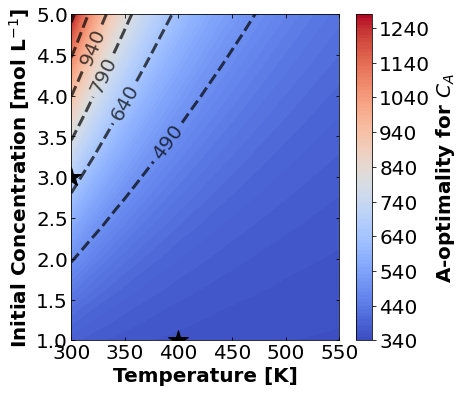

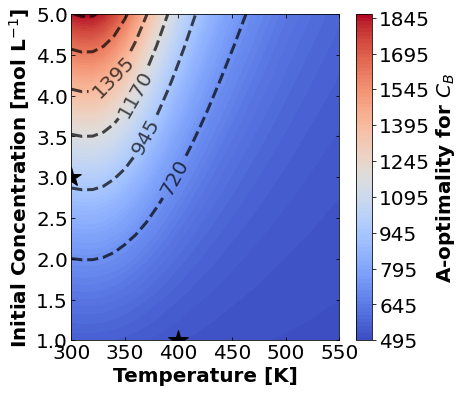

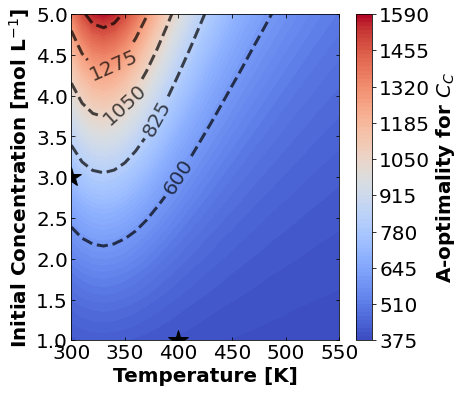

In [35]:
for k,m in enumerate(measurements):
    create_contour_plot(Aopt[k].transpose(), "A-optimality for "+m, "%2.0f")

Likewise, let's make plots for D-optimality.

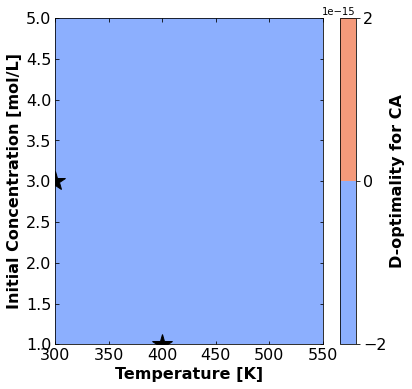

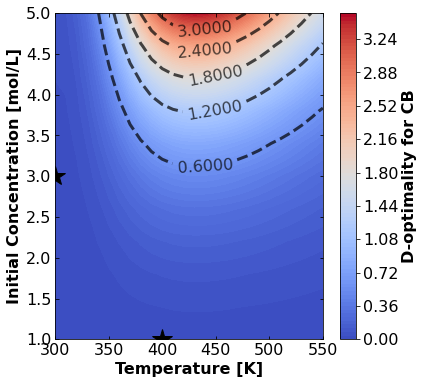

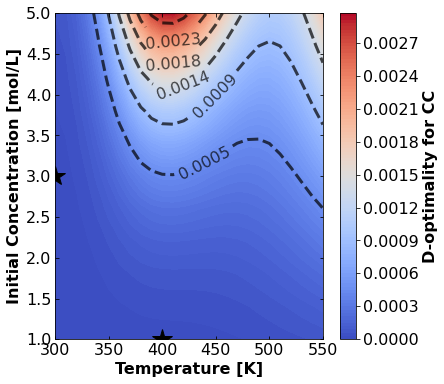

In [29]:
for k,m in enumerate(measurements):
    create_contour_plot(Dopt[k].transpose(), "D-optimality for "+m, "%2.4f")

And finally E-optimality.

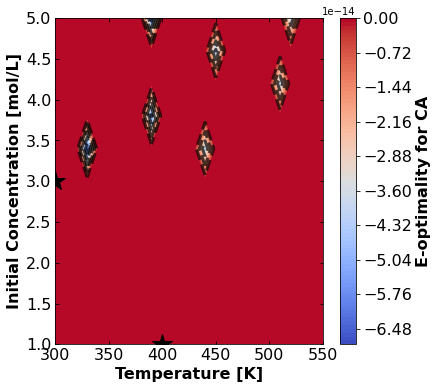

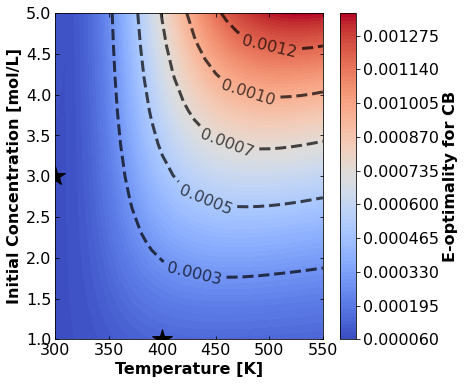

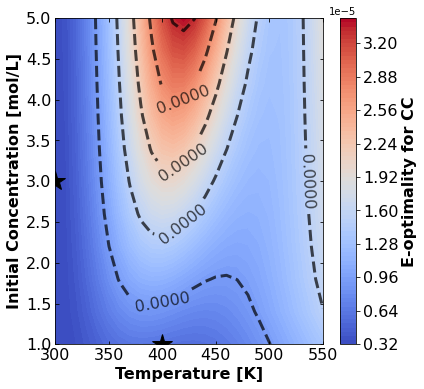

In [30]:
for k,m in enumerate(measurements):
    create_contour_plot(Eopt[k].transpose(), "E-optimality for "+m, "%2.4f")

**Discussion:**
* Based on the plots for D-, A-, and E-optimality, why is it a bad idea to only measure $C_{A}$? Using the mathematical model for the experiment, explain why this makes sense.
* Why is D- and E-optimality approximately an order of magnitude larger for measuring $C_{B}$ instead of $C_{C}$?
* Why do D- and E-optimality both recommend a third experiment at the maximum value for $C_{A0}$? Using the mathematical model and assumed measurement error structure, explain why this makes sense.

## Take Away Messages

* Fisher information matrix quantifies the value of data in the context of a mathematical model
* An eigendecomposition of the Fisher information matrix reveals which parameters are (locally) not identiafiable
* A-, D-, and E-optimality help inform which experimental conditions and measurements are most informative
* Heatmaps of these optimality matrics help build intuition about the model